# Reproducing Label Randomization Defense Results (Cora dataset)

To reproduce the results for the Label Randomization defense on the Cora dataset:

1. Open `scripts/run_defense_label_rand.sh`
2. Modify as needed:
   - `datasets` (default=Cora)
   - `experiment_name` (Name for the experiment, will be used as directory name for logs)
   - `label_defense_budgets` (Array of budget values to test for Label Randomization)
   - Modify the parallel parameter (-j) to adjust the number of concurrent jobs based on your system's capabilities

3. Make the script executable:
   ```
   chmod +x scripts/run_defense_label_rand.sh
   ```

4. Run the script:
   ```
   bash scripts/run_defense_label_rand.sh
   ```

Results will be logged locally and saved in the `logs/{experiment_name}` directory.

### Note on Label Randomization Defense:
Label Randomization defense randomly changes a portion of the training labels. This affects all attacks except the feature attack, as it modifies the training process and the resulting model. The `label_defense_budget` parameter determines the proportion of labels that are randomized.

### Parsing the results

After running the script, the logs of the experiments are stored in the directory `logs/Defense Label Randomization results Cora`.
The code below will parse these results to compute the average accuracy for the Gradient, Inter-Reps, Output Server, and Label attacks across multiple seeds and label defense budget values.

The attack methods are renamed in the results to match the names used in the paper:
- 'gradients' is used for the Gradient attack
- 'forward_values' is renamed to 'Inter-Reps'
- 'output_server' represents the Prediction Output attack
- 'labels' represents the Label attack

The resulting table will show how the accuracy of these four attacks changes with different label defense budget values for the Label Randomization defense. Note that the feature attack is not included as it remains unaffected by this defense mechanism.


|   Label Defense Budget | Gradients    | Inter-Reps   | Prediction Output   | Label        | Test Accuracy   |
|-----------------------:|:-------------|:-------------|:--------------------|:-------------|:----------------|
|                   0.05 | 78.96 ± 0.22 | 66.64 ± 0.68 | 77.38 ± 0.37        | 79.08 ± 0.14 | 73.76 ± 0.61    |
|                   0.10 | 76.02 ± 0.27 | 62.54 ± 0.46 | 74.31 ± 0.26        | 75.80 ± 0.20 | 71.82 ± 0.50    |
|                   0.20 | 68.52 ± 0.60 | 61.21 ± 0.83 | 70.33 ± 1.06        | 67.92 ± 0.28 | 68.30 ± 0.43    |
|                   0.30 | 63.68 ± 1.96 | 57.69 ± 0.85 | 63.61 ± 1.81        | 58.05 ± 0.28 | 59.26 ± 0.48    |
|                   0.40 | 65.80 ± 2.11 | 56.72 ± 0.79 | 59.75 ± 1.01        | 46.14 ± 0.28 | 53.61 ± 0.39    |
|                   0.50 | 62.60 ± 1.48 | 56.04 ± 0.46 | 56.68 ± 0.43        | 32.91 ± 0.35 | 45.16 ± 0.27    |
|                   0.60 | 58.31 ± 0.73 | 55.27 ± 1.02 | 53.66 ± 1.08        | 18.08 ± 0.30 | 35.37 ± 0.

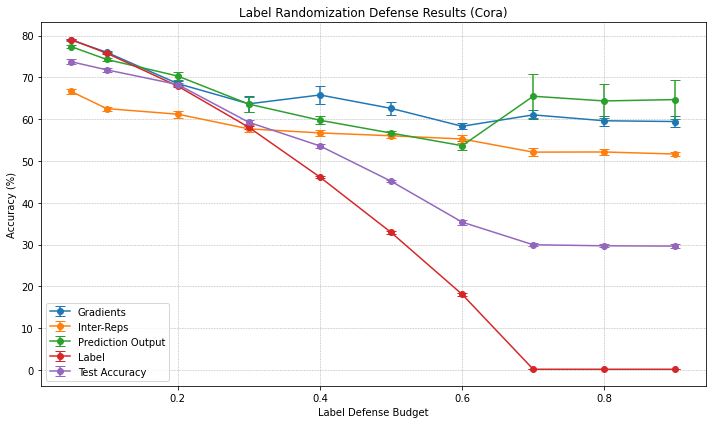

In [7]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def safe_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

def parse_results(experiment_dir):
    results = []
    for subdir in os.listdir(experiment_dir):
        csv_path = os.path.join(experiment_dir, subdir, 'attack_results.csv')
        config_path = os.path.join(experiment_dir, subdir, 'config.json')
        metrics_path = os.path.join(experiment_dir, subdir, 'metrics.csv')
        
        if os.path.exists(csv_path) and os.path.exists(config_path) and os.path.exists(metrics_path):
            with open(config_path, 'r') as f:
                config = json.load(f)
                label_defense_budget = config.get('label_defense_budget', None)
            
            if label_defense_budget is None:
                continue
            
            df = pd.read_csv(csv_path)
            accuracy_df = df[df['metric'].str.startswith('Accuracy-')].copy()
            accuracy_df['value'] = accuracy_df['value'].apply(safe_float)
            
            metrics_df = pd.read_csv(metrics_path)
            last_epoch = metrics_df['epoch'].max()
            test_accuracy_row = metrics_df[(metrics_df['epoch'] == last_epoch) & (metrics_df['metric'] == 'accuracy_test')]
            
            if test_accuracy_row.empty:
                print(f"Warning: No test accuracy found for {subdir}")
                continue
            
            test_accuracy = test_accuracy_row['value'].iloc[0]
            
            run_result = {
                'label_defense_budget': label_defense_budget,
                'seed': subdir,
                'test_accuracy': test_accuracy
            }
            
            for attack in ['gradients', 'forward_values', 'output_server', 'labels']:
                attack_results = accuracy_df[accuracy_df['metric'] == f'Accuracy-{attack}']
                if not attack_results.empty:
                    if attack == 'gradients':
                        accuracy = attack_results['value'].iloc[0]  # First epoch for gradient attack
                    else:
                        accuracy = attack_results['value'].iloc[-1]  # Last epoch for other attacks
                    attack_name = 'Inter-Reps' if attack == 'forward_values' else 'Gradients' if attack == 'gradients' else 'Prediction Output' if attack == 'output_server' else 'Label'
                    run_result[f'{attack_name}_accuracy'] = accuracy
            
            results.append(run_result)
    
    return pd.DataFrame(results)

experiment_dir = '../logs/Defense Label Randomization results Cora'
results_df = parse_results(experiment_dir)

if results_df.empty:
    print("No valid results found. Please check the experiment directory and data.")
else:
    # Group results by label_defense_budget and calculate mean and sem for all metrics
    grouped_results = results_df.groupby('label_defense_budget').agg({
        'Gradients_accuracy': ['mean', 'sem'],
        'Inter-Reps_accuracy': ['mean', 'sem'],
        'Prediction Output_accuracy': ['mean', 'sem'],
        'Label_accuracy': ['mean', 'sem'],
        'test_accuracy': ['mean', 'sem']
    }).reset_index()

    # Flatten column names
    grouped_results.columns = ['_'.join(col).strip() for col in grouped_results.columns.values]

    # Rename columns for clarity
    grouped_results = grouped_results.rename(columns={
        'label_defense_budget_': 'label_defense_budget',
        'Gradients_accuracy_mean': 'Gradients_mean',
        'Gradients_accuracy_sem': 'Gradients_sem',
        'Inter-Reps_accuracy_mean': 'Inter-Reps_mean',
        'Inter-Reps_accuracy_sem': 'Inter-Reps_sem',
        'Prediction Output_accuracy_mean': 'Prediction Output_mean',
        'Prediction Output_accuracy_sem': 'Prediction Output_sem',
        'Label_accuracy_mean': 'Label_mean',
        'Label_accuracy_sem': 'Label_sem',
        'test_accuracy_mean': 'test_accuracy_mean',
        'test_accuracy_sem': 'test_accuracy_sem'
    })

    # Sort by label_defense_budget in ascending order
    grouped_results = grouped_results.sort_values('label_defense_budget', ascending=True)

    # Format the table
    table_data = []
    for _, row in grouped_results.iterrows():
        table_data.append([
            f"{row['label_defense_budget']:.2f}",
            f"{row['Gradients_mean']*100:.2f} ± {row['Gradients_sem']*100:.2f}",
            f"{row['Inter-Reps_mean']*100:.2f} ± {row['Inter-Reps_sem']*100:.2f}",
            f"{row['Prediction Output_mean']*100:.2f} ± {row['Prediction Output_sem']*100:.2f}",
            f"{row['Label_mean']*100:.2f} ± {row['Label_sem']*100:.2f}",
            f"{row['test_accuracy_mean']*100:.2f} ± {row['test_accuracy_sem']*100:.2f}"
        ])

    # Create the table
    table = tabulate(table_data, headers=["Label Defense Budget", "Gradients", "Inter-Reps", "Prediction Output", "Label", "Test Accuracy"], 
                     tablefmt="pipe", floatfmt=".2f")

    print(table)

    # Plotting
    plt.figure(figsize=(10, 6))
    for attack in ['Gradients', 'Inter-Reps', 'Prediction Output', 'Label', 'test_accuracy']:
        mean_col = f'{attack}_mean'
        sem_col = f'{attack}_sem'
        label = 'Test Accuracy' if attack == 'test_accuracy' else attack
        plt.errorbar(grouped_results['label_defense_budget'], grouped_results[mean_col]*100, yerr=grouped_results[sem_col]*100, 
                     label=label, capsize=5, marker='o')

    plt.xlabel('Label Defense Budget')
    plt.ylabel('Accuracy (%)')
    plt.title('Label Randomization Defense Results (Cora)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
